# Binary Classification Model for [Project Name] Using Python version 10
### David Lowe
### April 12, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: [Sample Paragraph - The purpose of this project is to construct prediction model using various machine learning algorithms and to document the end-to-end steps using a template. The Connectionist Bench dataset is a classic binary classification situation where we are trying to predict one of the two possible outcomes.]

INTRODUCTION: [Sample Paragraph - The data file patterns obtained by bouncing sonar signals off a metal cylinder or a rock at various angles and under various conditions. The transmitted sonar signal is a frequency-modulated chirp, rising in frequency. The data set contains signals obtained from a variety of different aspect angles, spanning 90 degrees for the cylinder and 180 degrees for the rock. Each pattern is a set of 60 numbers in the range 0.0 to 1.0. Each number represents the energy within a particular frequency band, integrated over a certain period of time.]

ANALYSIS: [Sample Paragraph - The baseline performance of the machine learning algorithms achieved an average accuracy of 75.15%. Two algorithms (Bagged Decision Trees and Stochastic Gradient Boosting) achieved the top accuracy metrics after the first round of modeling. After a series of tuning trials, Stochastic Gradient Boosting turned in the top overall result and achieved an accuracy metric of 81.37%. By using the optimized parameters, the Stochastic Gradient Boosting algorithm processed the testing dataset with an accuracy of 87.30%, which was on-par with the prediction using the training data.]

CONCLUSION: [Sample Paragraph - For this iteration, the Stochastic Gradient Boosting algorithm achieved the best overall results using the training and testing datasets. For this dataset, Stochastic Gradient Boosting should be considered for further modeling or production use.]

Dataset Used: Connectionist Bench (Sonar, Mines vs. Rocks) Data Set

Dataset ML Model: Binary classification with [numerical | categorical] attributes

Dataset Reference: [https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+%28Sonar%2C+Mines+vs.+Rocks%29]

One potential source of performance benchmark: [https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+%28Sonar%2C+Mines+vs.+Rocks%29]

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Problem
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Problem
### 1.a) Load ibraries

In [1]:
import math
import numpy as np
import pandas as pd
import os
import sys
import shutil
import urllib.request
import zipfile
import warnings
import smtplib
from datetime import datetime
from email.message import EmailMessage
from matplotlib import pyplot
from pandas import read_csv
from pandas import get_dummies
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
# from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

# Create one random seed number for reproducible results
seedNum = 888

### 1.b) Set up the email notification function

In [2]:
def email_notify(msg_text):
    sender = os.environ.get('MAIL_USERNAME')
    password = os.environ.get('MAIL_PASSWORD')
    receiver = os.environ.get('MAIL_RECEIVER')
    if sender==None or password==None or receiver==None :
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(sender, password)
    server.send_message(msg)
    server.quit()

In [3]:
email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [4]:
startTimeScript = datetime.now()

dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'
dest_file = os.path.basename(dataset_path)
if (os.path.isfile(dest_file) == False) :
    print('Downloading ' + dataset_path + ' as ' + dest_file)
    with urllib.request.urlopen(dataset_path) as in_resp, open(dest_file, 'wb') as out_file:
        shutil.copyfileobj(in_resp, out_file)
    print(dest_file + 'downloaded!')
#     print('Unpacking ' + dest_file)
#     with zipfile.ZipFile(dest_file, 'r') as zip_ref:
#         zip_ref.extractall('.')
#     print(dest_file + 'unpacked!')

inputFile = dest_file
attrNames = ['attr' + str(i).zfill(2) for i in range(1,61)]
colNames = attrNames + ['targetVar']
xy_original_df = read_csv(inputFile, names=colNames, sep=',', header=None, index_col=False)

In [5]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(xy_original_df.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

In [6]:
# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

# Standardize the class column to the name of targetVar if required
# xy_original_df = xy_original_df.rename(columns={'outcome': 'targetVar'})

In [7]:
# We create training datasets (xy_train_df, x_train_df, y_train_df) for various visualization and cleaning/transformation operations
# We create testing datasets (x_test_df, y_test_df) for various visualization and cleaning/transformation operations
# Use 70% of the data to train the models and the remaining for testing/validation

if targetCol == totCol:
    x_original_df = xy_original_df.iloc[:,0:totAttr]
    y_original_df = xy_original_df.iloc[:,totAttr]
else:
    x_original_df = xy_original_df.iloc[:,1:totCol]
    y_original_df = xy_original_df.iloc[:,0]

validation_size = 0.30
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x_original_df, y_original_df, test_size=validation_size, random_state=seedNum)
xy_train_df = pd.concat([x_train_df, y_train_df], axis=1)
print("xy_original_df.shape: {} xy_train_df.shape: {}".format(xy_original_df.shape, xy_train_df.shape))
print("x_train_df.shape: {} y_train_df.shape: {}".format(x_train_df.shape, y_train_df.shape))
print("x_test_df.shape: {} y_test_df.shape: {}".format(x_test_df.shape, y_test_df.shape))

xy_original_df.shape: (208, 61) xy_train_df.shape: (145, 61)
x_train_df.shape: (145, 60) y_train_df.shape: (145,)
x_test_df.shape: (63, 60) y_test_df.shape: (63,)


### 1.d) Set up the key parameters to be used in the script

In [8]:
# Set up the number of CPU cores available for multi-thread processing
cpu_num = None

# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
pyplot.rcParams["figure.figsize"] = fig_size

# Set the warning message filter
warnings.filterwarnings("ignore", category=FutureWarning)

In [9]:
email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [10]:
email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive statistics

#### 2.a.i) Peek at the data itself.

In [11]:
xy_train_df.head()

attr01  attr02  attr03  attr04  attr05  attr06  attr07  attr08  attr09  \
40   0.0068  0.0232  0.0513  0.0444  0.0249  0.0637  0.0422  0.1130  0.1911   
151  0.0231  0.0315  0.0170  0.0226  0.0410  0.0116  0.0223  0.0805  0.2365   
146  0.1021  0.0830  0.0577  0.0627  0.0635  0.1328  0.0988  0.1787  0.1199   
125  0.0228  0.0853  0.1000  0.0428  0.1117  0.1651  0.1597  0.2116  0.3295   
176  0.0635  0.0709  0.0453  0.0333  0.0185  0.1260  0.1015  0.1918  0.3362   

     attr10  ...  attr52  attr53  attr54  attr55  attr56  attr57  attr58  \
40   0.2475  ...  0.0173  0.0163  0.0055  0.0045  0.0068  0.0041  0.0052   
151  0.2461  ...  0.0125  0.0036  0.0123  0.0043  0.0114  0.0052  0.0091   
146  0.1369  ...  0.0709  0.0317  0.0309  0.0252  0.0087  0.0177  0.0214   
125  0.3517  ...  0.0172  0.0191  0.0260  0.0140  0.0125  0.0116  0.0093   
176  0.3900  ...  0.0048  0.0025  0.0087  0.0072  0.0095  0.0086  0.0085   

     attr59  attr60  targetVar  
40   0.0194  0.0105          R  
151  0.0008  0.0092          M  
146  0.0227  0.0106          M  
125  0.0012  0.0036          M  
176  0.0040  0.0051          M  

[5 rows x 61 columns]

#### 2.a.ii) Dimensions of the dataset.

In [12]:
xy_train_df.shape

(145, 61)

#### 2.a.iii) Types of the attributes.

In [13]:
xy_train_df.info()
xy_train_df.dtypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 40 to 154
Data columns (total 61 columns):
attr01       145 non-null float64
attr02       145 non-null float64
attr03       145 non-null float64
attr04       145 non-null float64
attr05       145 non-null float64
attr06       145 non-null float64
attr07       145 non-null float64
attr08       145 non-null float64
attr09       145 non-null float64
attr10       145 non-null float64
attr11       145 non-null float64
attr12       145 non-null float64
attr13       145 non-null float64
attr14       145 non-null float64
attr15       145 non-null float64
attr16       145 non-null float64
attr17       145 non-null float64
attr18       145 non-null float64
attr19       145 non-null float64
attr20       145 non-null float64
attr21       145 non-null float64
attr22       145 non-null float64
attr23       145 non-null float64
attr24       145 non-null float64
attr25       145 non-null float64
attr26       145 non-null float64
attr27    

attr01       float64
attr02       float64
attr03       float64
attr04       float64
attr05       float64
attr06       float64
attr07       float64
attr08       float64
attr09       float64
attr10       float64
attr11       float64
attr12       float64
attr13       float64
attr14       float64
attr15       float64
attr16       float64
attr17       float64
attr18       float64
attr19       float64
attr20       float64
attr21       float64
attr22       float64
attr23       float64
attr24       float64
attr25       float64
attr26       float64
attr27       float64
attr28       float64
attr29       float64
attr30       float64
              ...   
attr32       float64
attr33       float64
attr34       float64
attr35       float64
attr36       float64
attr37       float64
attr38       float64
attr39       float64
attr40       float64
attr41       float64
attr42       float64
attr43       float64
attr44       float64
attr45       float64
attr46       float64
attr47       float64
attr48       

#### 2.a.iv) Statistical summary of all attributes.

In [14]:
xy_train_df.describe()

attr01      attr02      attr03      attr04      attr05      attr06  \
count  145.000000  145.000000  145.000000  145.000000  145.000000  145.000000   
mean     0.029052    0.040279    0.047516    0.055762    0.076861    0.107283   
std      0.023359    0.034416    0.042145    0.050038    0.058099    0.054484   
min      0.001500    0.001700    0.001500    0.006100    0.007600    0.010200   
25%      0.013100    0.017300    0.020200    0.024700    0.035200    0.069000   
50%      0.022800    0.031800    0.036700    0.044400    0.064700    0.101900   
75%      0.036300    0.049100    0.062100    0.068100    0.104300    0.142800   
max      0.137100    0.233900    0.305900    0.426400    0.401000    0.307000   

           attr07      attr08      attr09      attr10  ...      attr51  \
count  145.000000  145.000000  145.000000  145.000000  ...  145.000000   
mean     0.122186    0.135619    0.181680    0.213862  ...    0.017048   
std      0.056682    0.080501    0.116801    0.126516  ...    0.013072   
min      0.013000    0.005500    0.007500    0.011300  ...    0.000900   
25%      0.084100    0.081700    0.103000    0.119900  ...    0.008600   
50%      0.111000    0.117800    0.156900    0.204800  ...    0.015100   
75%      0.154300    0.169400    0.236500    0.279500  ...    0.021600   
max      0.301600    0.456600    0.682800    0.619400  ...    0.100400   

           attr52      attr53      attr54      attr55      attr56      attr57  \
count  145.000000  145.000000  145.000000  145.000000  145.000000  145.000000   
mean     0.014352    0.010912    0.011557    0.009866    0.008472    0.007699   
std      0.010275    0.007065    0.007604    0.007355    0.006109    0.005780   
min      0.000800    0.000500    0.001000    0.000600    0.000400    0.000900   
25%      0.007700    0.005400    0.005600    0.004600    0.004200    0.003800   
50%      0.011900    0.009800    0.009600    0.007900    0.006900    0.005900   
75%      0.017300    0.015200    0.015000    0.012400    0.011100    0.009900   
max      0.070900    0.036100    0.035200    0.044700    0.039400    0.035500   

           attr58      attr59      attr60  
count  145.000000  145.000000  145.000000  
mean     0.008777    0.008386    0.006664  
std      0.006928    0.006345    0.004470  
min      0.000600    0.000100    0.000600  
25%      0.004500    0.004300    0.003300  
50%      0.006600    0.007000    0.005500  
75%      0.011300    0.010700    0.009000  
max      0.044000    0.036400    0.023100  

[8 rows x 60 columns]

#### 2.a.v) Count missing values.

In [15]:
print('Number of NaN in the dataframe columns:\n', xy_train_df.isnull().sum())
print('Total number of NaN in the dataframe: ', xy_train_df.isnull().sum().sum())

Number of NaN in the dataframe columns:
 attr01       0
attr02       0
attr03       0
attr04       0
attr05       0
attr06       0
attr07       0
attr08       0
attr09       0
attr10       0
attr11       0
attr12       0
attr13       0
attr14       0
attr15       0
attr16       0
attr17       0
attr18       0
attr19       0
attr20       0
attr21       0
attr22       0
attr23       0
attr24       0
attr25       0
attr26       0
attr27       0
attr28       0
attr29       0
attr30       0
            ..
attr32       0
attr33       0
attr34       0
attr35       0
attr36       0
attr37       0
attr38       0
attr39       0
attr40       0
attr41       0
attr42       0
attr43       0
attr44       0
attr45       0
attr46       0
attr47       0
attr48       0
attr49       0
attr50       0
attr51       0
attr52       0
attr53       0
attr54       0
attr55       0
attr56       0
attr57       0
attr58       0
attr59       0
attr60       0
targetVar    0
Length: 61, dtype: int64
Total number of NaN

#### 2.a.vi) Summarize the levels of the class attribute.

In [16]:
xy_train_df.groupby('targetVar').size()

targetVar
M    86
R    59
dtype: int64

### 2.b) Data visualizations

##### 2.b.i) Univariate plots to better understand each attribute

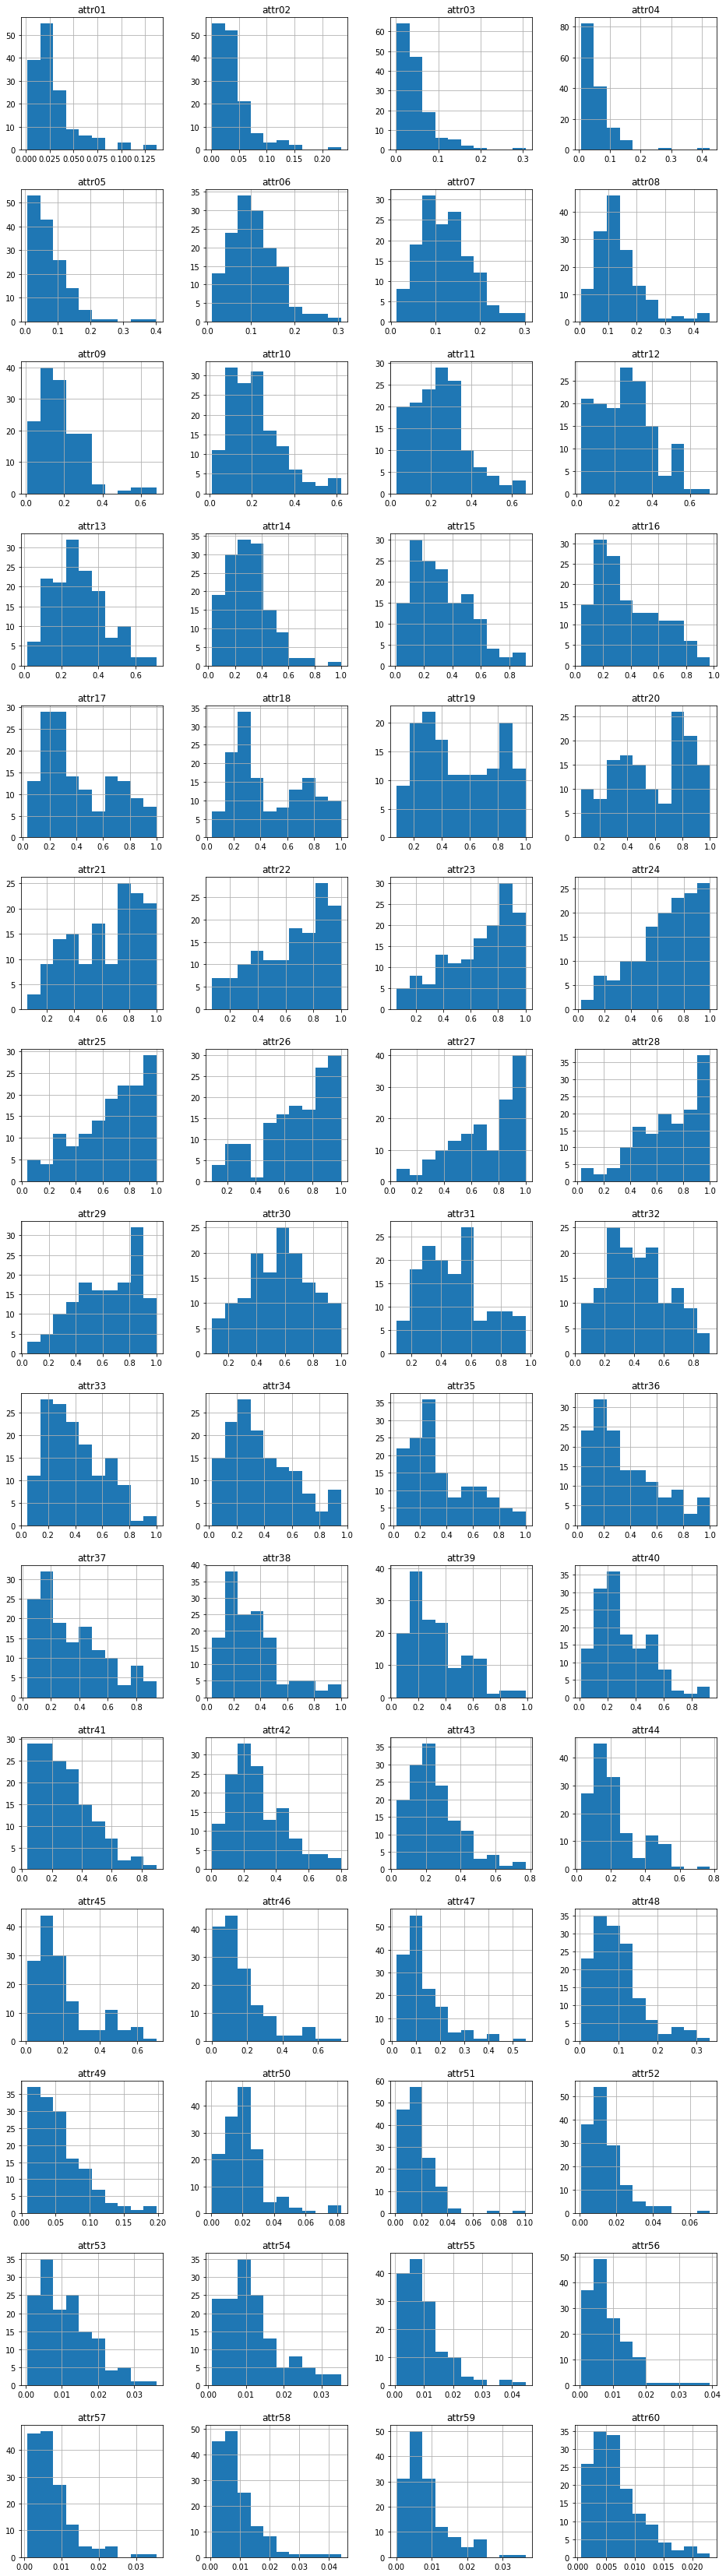

In [17]:
# Histograms for each attribute
x_train_df.hist(layout=(dispRow,dispCol))
pyplot.show()

In [18]:
# Density plot for each attribute
x_train_df.plot(kind='density', subplots=True, layout=(dispRow,dispCol))
pyplot.show()

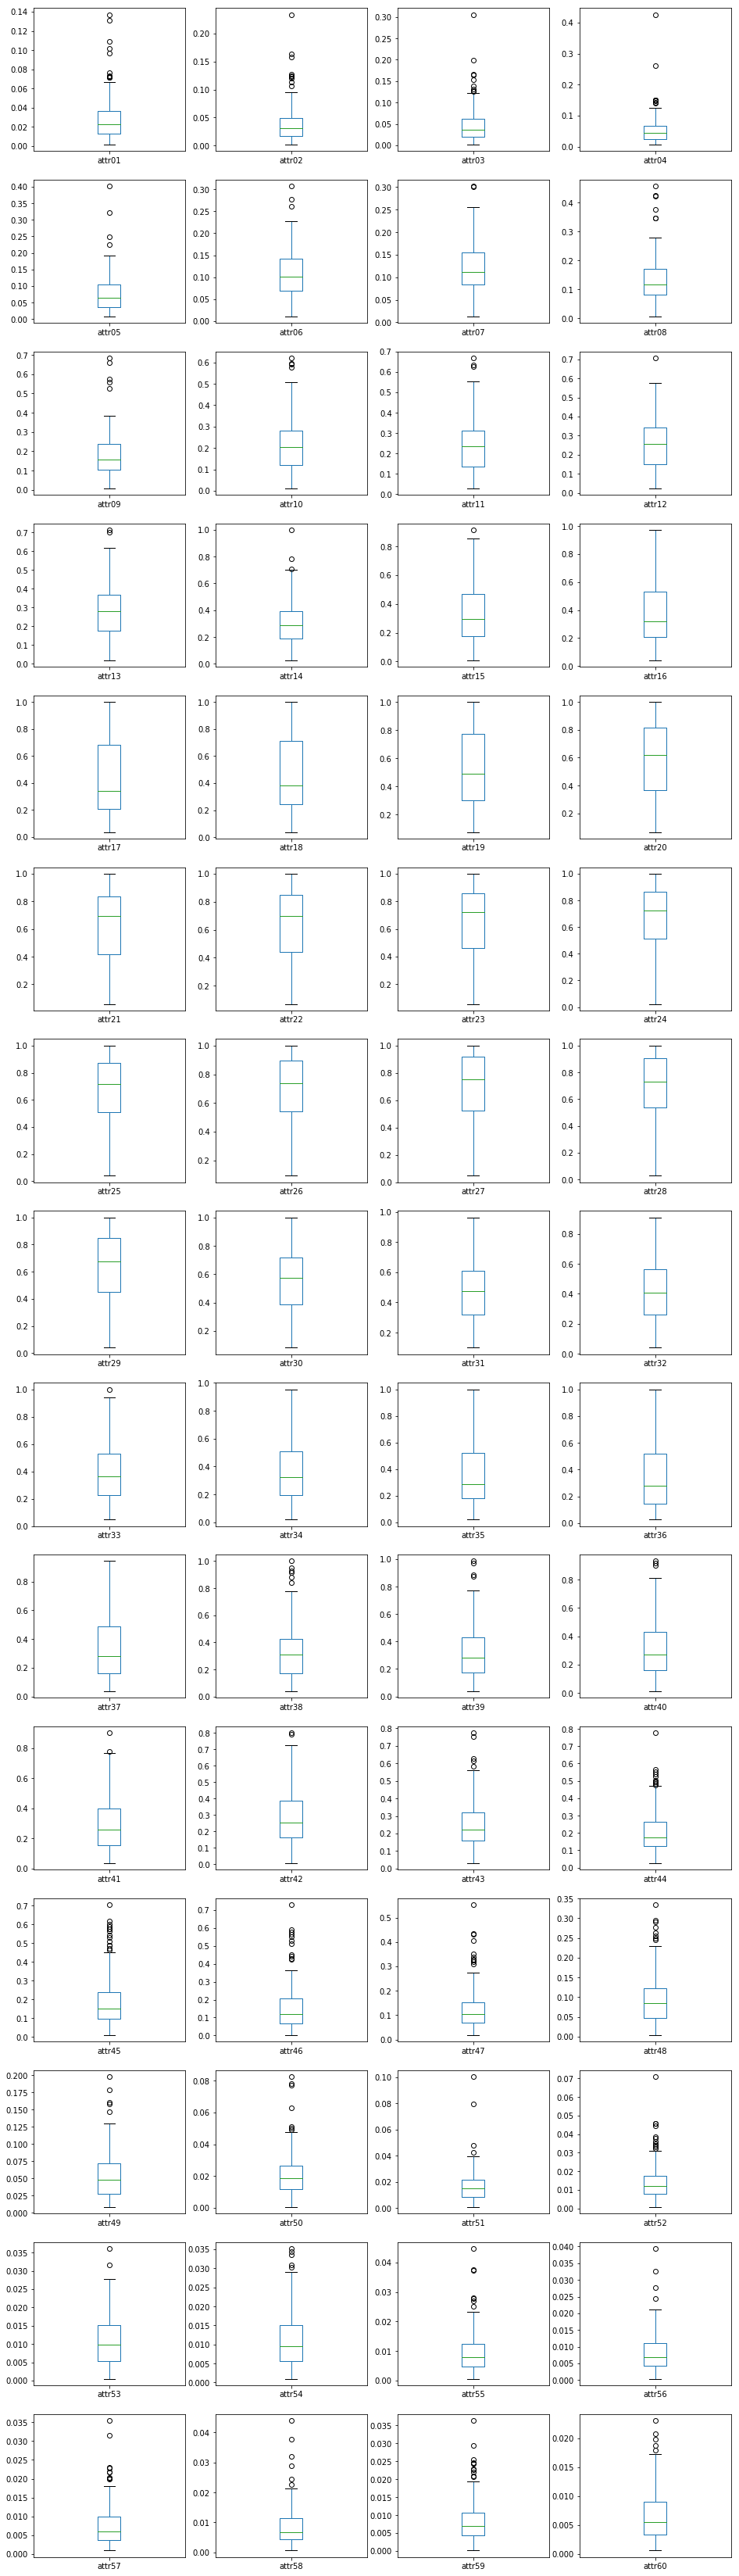

In [19]:
# Box and Whisker plot for each attribute
x_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
pyplot.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [20]:
# Scatterplot matrix
# scatter_matrix(x_train_df)
# pyplot.show()

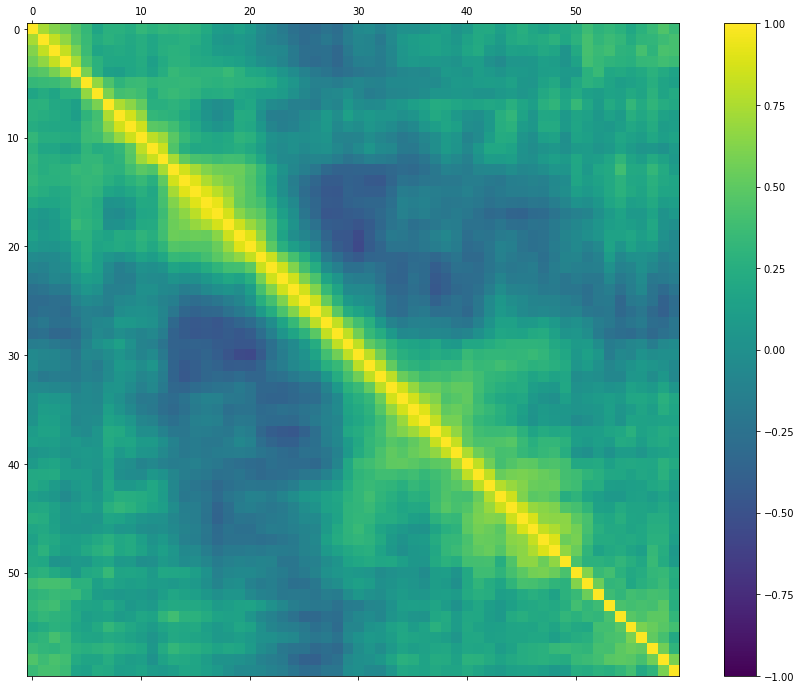

In [21]:
# Correlation matrix
fig = pyplot.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = x_train_df.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
pyplot.show()

In [22]:
email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [23]:
email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Data Cleaning

In [24]:
# Not applicable for this iteration of the project
# Sample code for performing one-hot-encoding (Block #1 of 2)
# According to the data dictionary, columns SOME_ATTR should be converted to categorical type
# x_train_df['SOME_ATTR'] = x_train_df['SOME_ATTR'].astype('category')

# # Apply the One-Hot-Encoding (dummy variable handling) technique
# x_train_df = get_dummies(x_train_df)
# print(x_train_df.dtypes)

In [25]:
# Sample code for performing one-hot-encoding (Block #2 of 2)
# According to the data dictionary, columns SOME_ATTR should be converted to categorical type
# x_train_df['SOME_ATTR'] = x_train_df['SOME_ATTR'].astype('category')

# # Apply the One-Hot-Encoding (dummy variable handling) technique
# x_test_df = get_dummies(x_test_df)
# print(x_test_df.dtypes)

### 3.b) Feature Selection

In [26]:
# Not applicable for this iteration of the project
# Sample Code for finding collinear features (Block #1 of 3)
# def findCorrelated(corrmat, cutoff = 0.75):    

# ### search correlation matrix and identify pairs that if removed would reduce pair-wise correlations
# # args:
#     # corrmat: a correlation matrix
#     # cutoff: pairwise absolute correlation cutoff
# # returns:
#     # variables to removed

#     if(len(corrmat) != len(corrmat.columns)) : return 'Correlation matrix is not square'
#     averageCorr = corrmat.abs().mean(axis = 1)

#     # set lower triangle and diagonal of correlation matrix to NA
#     for row in range(0, len(corrmat)):
#         for col in range(0, (row+1)):
#             corrmat.iloc[row, col] = None

#     # where a pairwise correlation is greater than the cutoff value, check whether mean abs.corr of a or b is greater and cut it
#     to_delete = list()
#     for col in range(0, len(corrmat.columns)):
#         for row in range(0, len(corrmat)):
#             if(abs(corrmat.iloc[row, col]) > cutoff):
#                 if(averageCorr.iloc[row] > averageCorr.iloc[col]): to_delete.append(row)
#                 else: to_delete.append(col)

#     to_delete = list(set(to_delete))
#     return to_delete

In [27]:
# Sample Code for finding collinear features (Block #2 of 3)
# By using the calculated correlation matrix, find the collinear features
# collinear = findCorrelated(correlations, cutoff = 0.75)
# print('Number of attributes to be removed:', len(collinear))
# dropAttributes = x_train_df.columns[collinear]
# print('Columns to be removed:')
# print(dropAttributes)

In [28]:
# Sample Code for finding collinear features (Block #3 of 3)
# Drop the highly collinear features
# x_train_df.drop(labels=dropAttributes, axis=1, inplace=True)
# x_test_df.drop(labels=dropAttributes, axis=1, inplace=True)

In [29]:
# Not applicable for this iteration of the project
# Sample code for performing Attribute Importance Ranking (Block #1 of 3)
# Feature Importance with Gradient Boosting Classifier
# x_impVal = x_train_df.values
# y_impVal = y_train_df.values.ravel()
# model = GradientBoostingClassifier(random_state=seedNum)
# model.fit(x_impVal, y_impVal)
# importanceScore = model.feature_importances_
# attributeList = x_train_df.columns.tolist()
# attributeImportance = pd.DataFrame({'attribute': attributeList, 'importance': importanceScore})
# rankedAttributes = attributeImportance.sort_values('importance', ascending=False)
# print(rankedAttributes)

In [30]:
# Sample code for performing Attribute Importance Ranking (Block #2 of 3)
# Set the importance threshold and calculate the list of attributes that don't contribute to the importance threshold
# importanceSum = sum(importanceScore)
# maxThreshold = 0.99
# i = 0
# accumWeight = 0
# exit_now = False
# while ((i < totAttr) and (not exit_now)) :
#     accumWeight = accumWeight + (rankedAttributes.iloc[i]['importance']/importanceSum)
#     if (accumWeight >= maxThreshold) :
#         exit_now = True
#     else :
#         i = i + 1
# print('Number of attributes contributed to the importance threshold:'+str(i))
# lowAttributes = rankedAttributes.iloc[(i):(totAttr),]['attribute'].tolist()
# print('Number of attributes found to be of low importance:',len(lowAttributes))
# print(lowAttributes)

In [31]:
# Sample code for performing Attribute Importance Ranking (Block #3 of 3)
# Removing the unselected attributes from the training and validation dataframes
# x_train_df.drop(labels=lowAttributes, axis=1, inplace=True)
# x_test_df.drop(labels=lowAttributes, axis=1, inplace=True)

In [32]:
# Not applicable for this iteration of the project
# Sample code for performing Recursive Feature Elimination (Block #1 of 3)
# Using the Logistic Regression algorithm, we perform the Recursive Feature Elimination (RFE) technique
# x_rfeVal = x_train_df.values
# y_rfeVal = y_train_df.values.ravel()
# estimator = LogisticRegression(random_state=seedNum)
# selector = RFE(estimator, 40)
# selector = selector.fit(x_rfeVal, y_rfeVal)
# print('The number of selected features:',selector.n_features_)
# print('The mask of selected features:\n',selector.support_)
# print('The mask of selected features:\n',selector.ranking_)

In [33]:
# Sample code for performing Recursive Feature Elimination (Block #2 of 3)
# Remove the unselected attributes from the training dataframes
# x_train_df = x_train_df[x_train_df.columns[selector.support_]]
# print(x_train_df.shape)
# x_train_df.head()

In [34]:
# Sample code for performing Recursive Feature Elimination (Block #3 of 3)
# Remove the unselected attributes from the validation dataframes
# x_test_df = x_test_df[x_test_df.columns[selector.support_]]
# print(x_test_df.shape)
# x_test_df.head()

### 3.c) Data Transforms

In [35]:
# Not applicable for this iteration of the project
# Sample code for performing SMOTE transformation on the training data (Block #1 of 2)
# x_train_imbal = x_train_df.values
# y_train_imbal = y_train_df.values.ravel()
# print("x_train_imbal.shape: {} y_train_imbal.shape: {}".format(x_train_imbal.shape, y_train_imbal.shape))

In [36]:
# Sample code for performing SMOTE transformation on the training data (Block #2 of 2)
# print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
# sm = SMOTE(random_state=seedNum, sampling_strategy=1.0)
# x_train, y_train = sm.fit_sample(x_train_imbal, y_train_imbal)
# print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

### 3.d) Display the Final Datasets for Model-Building

In [37]:
# We finalize the training and testing datasets for the modeling activities
x_train = x_train_df.values
y_train = y_train_df.values
x_test = x_test_df.values
y_test = y_test_df.values
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))
email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

x_train.shape: (145, 60) y_train.shape: (145,)
x_test.shape: (63, 60) y_test.shape: (63,)


## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, two non-linear and four ensemble algorithms:

Linear Algorithm: Logistic Regression

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Bagged CART, Random Forest, Extra Trees, and Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [38]:
# Run algorithms using 10-fold cross validation
num_folds = 10
scoring = 'accuracy'

In [39]:
# Set up Algorithms Spot-Checking Array
models = []
models.append(('LR', LogisticRegression(random_state=seedNum, n_jobs=cpu_num)))
models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
models.append(('KNN', KNeighborsClassifier(n_jobs=cpu_num)))
models.append(('BT', BaggingClassifier(random_state=seedNum, n_jobs=cpu_num)))
models.append(('RF', RandomForestClassifier(random_state=seedNum, n_jobs=cpu_num)))
models.append(('ET', ExtraTreesClassifier(random_state=seedNum, n_jobs=cpu_num)))
models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
# models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=cpu_num)))
results = []
names = []
metrics = []

In [40]:
# Generate model in turn
for name, model in models:
	email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=num_folds, random_state=seedNum)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	metrics.append(cv_results.mean())
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
	print ('Model training time:',(datetime.now() - startTimeModule))
	email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(metrics))

LR: 0.746190 (0.123278)
Model training time: 0:00:00.022986
CART: 0.675238 (0.132528)
Model training time: 0:00:00.033954
KNN: 0.746667 (0.154916)
Model training time: 0:00:00.021971
BT: 0.780476 (0.107969)
Model training time: 0:00:00.217249
RF: 0.745714 (0.142781)
Model training time: 0:00:00.100867
ET: 0.772857 (0.087054)
Model training time: 0:00:00.092929
GBM: 0.793810 (0.097289)
Model training time: 0:00:00.962571
Average metrics (accuracy) from all models: 0.7515646258503402


### 4.b) Spot-checking baseline algorithms

In [41]:
fig = pyplot.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [42]:
# Set up the comparison array
results = []
names = []

In [43]:
# Tuning algorithm #1 - Bagged Decision Trees
email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid1 = dict(n_estimators=np.array([50,100,150,200,250]))
model1 = BaggingClassifier(random_state=seedNum, n_jobs=cpu_num)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
results.append(grid_result1.cv_results_['mean_test_score'])
names.append('BT')
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

C:\Users\david.lowe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.779310 using {'n_estimators': 100}
0.765517 (0.129771) with: {'n_estimators': 50}
0.779310 (0.122101) with: {'n_estimators': 100}
0.765517 (0.116432) with: {'n_estimators': 150}
0.765517 (0.116432) with: {'n_estimators': 200}
0.758621 (0.120052) with: {'n_estimators': 250}
Model training time: 0:00:16.575931


In [44]:
# Tuning algorithm #2 - Gradient Boosting
email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid2 = dict(n_estimators=np.array([50,100,150,200,250]))
model2 = GradientBoostingClassifier(random_state=seedNum)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
results.append(grid_result2.cv_results_['mean_test_score'])
names.append('GBM')
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

C:\Users\david.lowe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.813793 using {'n_estimators': 150}
0.765517 (0.121403) with: {'n_estimators': 50}
0.793103 (0.096499) with: {'n_estimators': 100}
0.813793 (0.091549) with: {'n_estimators': 150}
0.813793 (0.091549) with: {'n_estimators': 200}
0.813793 (0.091549) with: {'n_estimators': 250}
Model training time: 0:00:06.774453


### 5.b) Compare Algorithms After Tuning

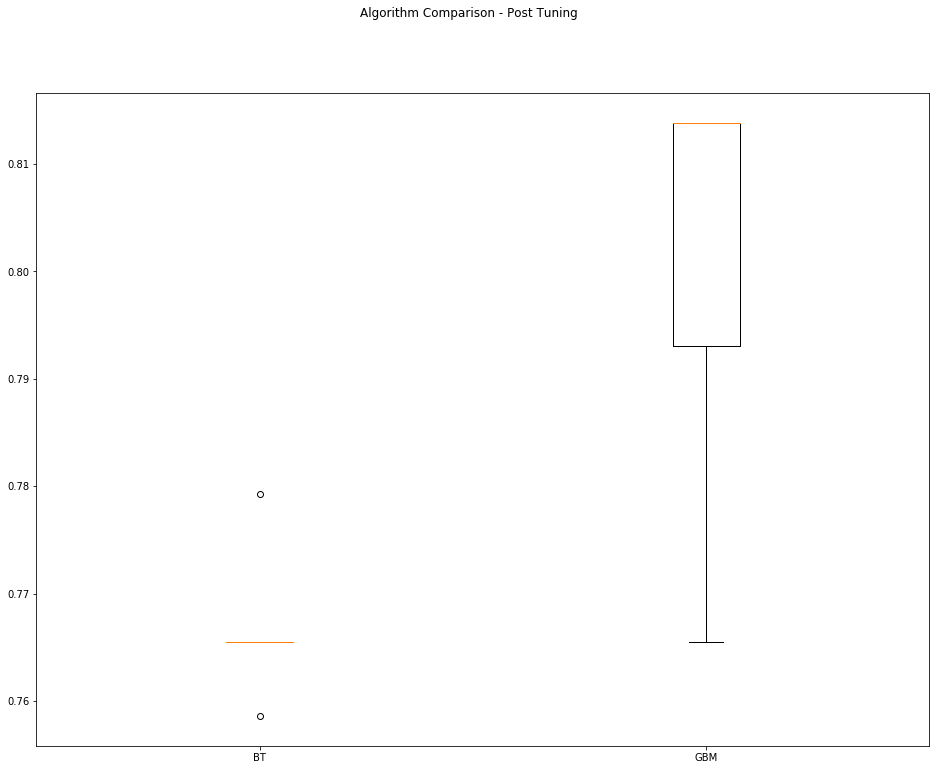

In [45]:
fig = pyplot.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [46]:
email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Predictions on validation dataset

In [47]:
model = GradientBoostingClassifier(n_estimators=150, random_state=seedNum)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.873015873015873
[[25  0]
 [ 8 30]]
              precision    recall  f1-score   support

           M       0.76      1.00      0.86        25
           R       1.00      0.79      0.88        38

   micro avg       0.87      0.87      0.87        63
   macro avg       0.88      0.89      0.87        63
weighted avg       0.90      0.87      0.87        63



### 6.b) Create standalone model on entire training dataset

In [48]:
startTimeModule = datetime.now()

# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
x_complete = np.vstack((x_train, x_test))
y_complete = np.concatenate((y_train, y_test))
print("x_complete.shape: {} y_complete.shape: {}".format(x_complete.shape, y_complete.shape))

finalModel = GradientBoostingClassifier(n_estimators=150, random_state=seedNum)
finalModel.fit(x_complete, y_complete)
print ('Model training time:',(datetime.now() - startTimeModule))

x_complete.shape: (208, 60) y_complete.shape: (208,)
Model training time: 0:00:00.280984


### 6.c) Save model for later use

In [49]:
# modelName = 'finalModel_BinaryClass.sav'
# dump(finalModel, modelName)

In [50]:
email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:01:22.231763
